In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install rdkit-pypi
!pip install ogb

## Importamos las librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Torch
import torch
from torch.nn import Linear
import torch.nn.functional as F

# Pytorch geometric modules
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

# For Dataset generation and visualization
from rdkit import Chem
from ogb.graphproppred.mol_encoder import AtomEncoder
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

# Extras
import os.path as osp

from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from math import sqrt



## Dataset visualization

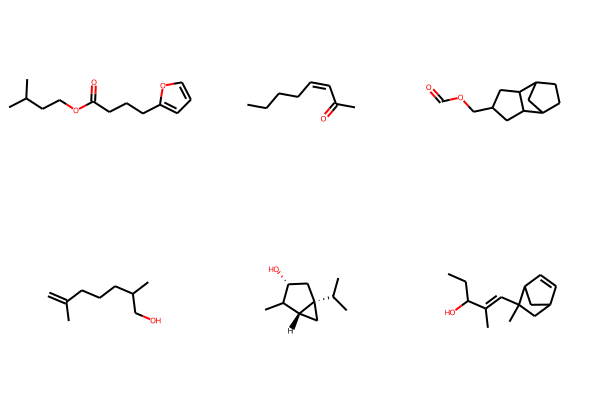

In [ ]:
csv_path = '/content/drive/MyDrive/GNN/smells/1_train_dummie.csv'

molecules = pd.read_csv(csv_path).sample(10).values

ms = [Chem.MolFromSmiles(x) for x in molecules[:, 0][0:6]]
Draw.MolsToGridImage(ms)

## Data Handling of Graphs

In [ ]:
class moleculesDS(InMemoryDataset):
  def __init__(self, root, csv_path, transform=None, pre_transform=None):
    self.csv_path = csv_path
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])


  @property
  def raw_file_names(self):
    return []
    

  @property
  def processed_file_names(self):
    files = 'mol_smells.pt'
    return files


  def download(self):
    pass

  def process(self):
    data_list = []
    molecules = pd.read_csv(self.csv_path).values

    for smiles, label_words, *labels in molecules:
      y = torch.tensor([labels], dtype=torch.long)#.view(-1)
      
      # Throw molecules in wich molecules can not be obtanined
      try:
        mol = Chem.MolFromSmiles(smiles)
      except:
        mol = None
      if mol is None:
          continue

      all_node_feats = []
      for atom in mol.GetAtoms():
          node_feats = atom_to_feature_vector(atom)
          all_node_feats.append(node_feats)

      all_node_feats = np.asarray(all_node_feats)
      x = torch.tensor(all_node_feats, dtype=torch.long).view(-1, 9)

      edge_attr = []
      edge_index = []
      for bond in mol.GetBonds():

          bond_feats = bond_to_feature_vector(bond)
          edge_attr.append([bond_feats, bond_feats])

          i = bond.GetBeginAtomIdx()
          j = bond.GetEndAtomIdx()
          edge_index += [[i, j], [j, i]]


      edge_attr = torch.tensor(edge_attr)
      edge_attr = edge_attr.to(torch.long).view(-1, 3)

      edge_index = torch.tensor(edge_index)
      edge_index = edge_index.t().to(torch.long).view(2, -1)


      data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y, smiles=smiles)
      data_list.append(data)

    if self.pre_transform is not None:
      data_list = [self.pre_transform(data) for data in data_list]

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


# Dataset generation: 
* train_dataset
* test_dataset

In [ ]:
# Dataset for training
train_dataset = moleculesDS(root = '/content/drive/MyDrive/GNN/training', csv_path = '/content/drive/MyDrive/GNN/smells/1_train_dummie.csv')
train_loader = DataLoader(train_dataset, batch_size = 80, shuffle=True)

# Dataset for testing
test_dataset = moleculesDS(root = '/content/drive/MyDrive/GNN/testing', csv_path = '/content/drive/MyDrive/GNN/smells/1_test_dummie.csv')
test_loader = DataLoader(test_dataset, batch_size = 80)


#Exploring the dataset

### training dataset

In [ ]:
train_dataset.data

Data(x=[55677, 9], edge_index=[2, 110424], edge_attr=[110424, 3], y=[4316, 109], smiles=[4316])

In [ ]:
train_dataset.data.y.shape

torch.Size([4316, 109])

In [ ]:
train_dataset.data.edge_attr[0]

tensor([0, 0, 0])

In [ ]:
train_dataset.num_node_features

9

### Test dataset

In [ ]:
test_dataset.data

Data(x=[4597, 9], edge_index=[2, 9084], edge_attr=[9084, 3], y=[388, 109], smiles=[388])

In [ ]:
test_dataset.data.y.shape

torch.Size([388, 109])

---

# Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.emb = AtomEncoder(9)
        
        self.drop = torch.nn.Dropout(0.20)

        self.conv1 = GATv2Conv(train_dataset.num_node_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):

        x = self.emb(x)

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop(x)

        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch) 

        x = F.dropout(x, p=0.4, training=self.training)
        x = self.lin(x)
        
        return x

# Training

In [ ]:


def train(dataloader, model, optimizer, criterion):
    loss_list = []
    train_acc_list = []

    model.train()
    total_loss = total_examples = 0
    correct = 0


    for data in dataloader:
      data = data.to(device)   
      optimizer.zero_grad()

      out = model(data.x, data.edge_index, data.batch)
      data.y = data.y.type_as(out)

      loss = criterion(out, data.y)
      loss.backward()

      optimizer.step()

      total_loss += float(loss) * data.num_graphs
      total_examples += data.num_graphs

      out = torch.sigmoid(out)
      out[ out >= 0.5 ] = 1.
      out[ out < 0.5 ] = 0.

      correct += int((out == data.y).sum()) 

    return sqrt(total_loss / total_examples), correct / (len(dataloader.dataset) * dataloader.dataset.data.y.shape[1])



@torch.no_grad()
def test(loader, model, criterion):

    main_true_rate = []
    correct = 0

    for i,data in enumerate(loader):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch) 

        out = torch.sigmoid(out)
        out[ out >= 0.5 ] = 1
        out[ out < 0.5 ] = 0

        true_rate = float( (out.to(dtype=torch.long) & data.y.to(dtype=torch.long)).sum() / data.y.sum() )
        main_true_rate.append(true_rate)

        
        correct += int((out == data.y).sum()) 

    test_acc = correct / ( len(loader.dataset)*loader.dataset.data.y.shape[1] )
    mean_true_rate = mean(main_true_rate)

    return test_acc, mean_true_rate 



def mean(list):
    return float(sum(list)/len(list))





### Calculating weigths for the training

In [ ]:
num_positives = torch.sum(train_dataset.data.y, dim=0)
num_negatives = len(train_dataset.data.y) - num_positives
pos_weight  = num_negatives / num_positives

## Training

Device is: cuda
Epoch: 000 | Test acc: 0.5461 | Train acc: 0.5467 | true_rate: 0.4665 | loss: 1.167007
Epoch: 010 | Test acc: 0.5581 | Train acc: 0.5602 | true_rate: 0.5860 | loss: 1.147473
Epoch: 020 | Test acc: 0.5728 | Train acc: 0.5754 | true_rate: 0.6084 | loss: 1.119085
Epoch: 030 | Test acc: 0.5927 | Train acc: 0.5984 | true_rate: 0.6148 | loss: 1.108998
Epoch: 040 | Test acc: 0.5977 | Train acc: 0.6049 | true_rate: 0.6134 | loss: 1.104255
Epoch: 050 | Test acc: 0.5992 | Train acc: 0.6046 | true_rate: 0.6080 | loss: 1.101078
Epoch: 060 | Test acc: 0.5991 | Train acc: 0.6055 | true_rate: 0.6046 | loss: 1.099619
Epoch: 070 | Test acc: 0.5978 | Train acc: 0.6059 | true_rate: 0.6229 | loss: 1.099301
Epoch: 080 | Test acc: 0.5981 | Train acc: 0.6082 | true_rate: 0.6075 | loss: 1.097305
Epoch: 090 | Test acc: 0.5976 | Train acc: 0.6074 | true_rate: 0.5981 | loss: 1.097910
Epoch: 100 | Test acc: 0.5991 | Train acc: 0.6068 | true_rate: 0.6126 | loss: 1.094393
Epoch: 110 | Test acc: 0.59

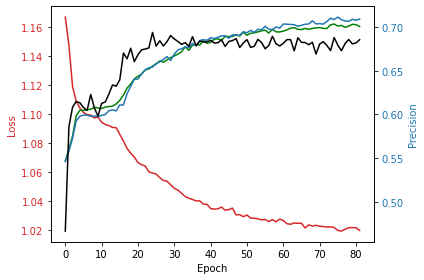

In [ ]:
from statistics import mean

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {device}')


model = GCN( hidden_channels=64 ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-4,
                            weight_decay=10**-3)


criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight ).to(device)

EPOCHS = 820
train_loss_list = []
train_acc_list = []
test_acc_list = []
true_rate_list = []

for epoch in range(EPOCHS):

    train_loss, train_acc = train(train_loader, model, optimizer, criterion)
    test_acc, true_rate = test(test_loader, model, criterion)

    if epoch % 10 == 0:
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        true_rate_list.append(true_rate)
        print(f'Epoch: {epoch:03d} | Test acc: {test_acc:.4f} | Train acc: {train_acc:.4f} | true_rate: {true_rate:.4f} | loss: {train_loss:.6f}')




# - - - - - - - - - - - - - - - - -
# Taken from matplotlib documentation

fig, ax1 = plt.subplots()
t = range(len(train_loss_list))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(t, train_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Precision', color=color)  

# TODO: Acumular test_acc train_acc y true_rate en un vector
ax2.plot(t, train_acc_list, color='green')
ax2.plot(t, test_acc_list, color=color)
ax2.plot(t, true_rate_list, color='black')

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

---

In [ ]:
PATH = '/content/drive/MyDrive/GNN/smells/SMELLS_model.pth'
# torch.save(model.state_dict(), PATH)